In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D, BatchNormalization
from tensorflow.keras.metrics import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import load_model # to save the model
from tensorflow.keras import layers, losses
from tensorflow.random import set_seed
from sklearn.metrics import confusion_matrix
from tensorflow.keras import regularizers 
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19
from keras.layers import BatchNormalization, Input
from keras.models import Model
from keras.regularizers import l1, l2
import cv2
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
image_array = np.load('../input/data-amazon-product-image-250-new/image_array.npy')
label_array = np.load('../input/data-amazon-product-image-250-new/label_array.npy')

In [3]:
train_images, test_images, train_labels, test_labels=train_test_split(image_array, label_array,
                                                                      test_size=0.1, random_state=42)
train_images, val_images, train_labels, val_labels=train_test_split(train_images, train_labels,
                                                                      test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

print('Number of   training samples : {}'.format(train_images.shape[0]))
print('Number of validation samples : {}'.format(val_images.shape[0]))
print('Number of       test samples : {}'.format(test_images.shape[0]))

Number of   training samples : 3592
Number of validation samples : 899
Number of       test samples : 500


In [4]:
input_tensor = Input(shape=(224, 224, 3))
vgg19_weight_path = '../input/full-keras-pretrained-no-top/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrain = VGG19(weights=vgg19_weight_path, include_top=False, input_tensor=input_tensor)

model = pretrain.layers[0].input
x = pretrain.layers[0].output

for i in range(len(pretrain.layers)):
    if i in [1,2,4,5,7,8,9,10,12,13,14,15,17,18,19,20]:
        x = pretrain.layers[i](x)
        x = BatchNormalization()(x)
    elif i in [3,6,11,16,21]:
        pretrain.layers[i].strides=(2,2)
        x = pretrain.layers[i](x)
    else:
        x = pretrain.layers[i](x)
NUM_CLASSES = 20
trained_model = tf.keras.Model(inputs=input_tensor, outputs=x)
trained_model.summary()

2022-10-05 13:21:32.427362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 13:21:32.549072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 13:21:32.549964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 13:21:32.552317: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[1][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
model = Sequential([
        trained_model,
        Flatten(),
        Dense(units=4096,kernel_regularizer=l2(0.00001), activation="relu"),
        Dropout(0.2),
        Dense(units=4096,kernel_regularizer=l2(0.00001), activation="relu"),
        Dropout(0.2),
        Dense(NUM_CLASSES, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 7, 7, 512)         20046400  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                8

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate = 0.0007, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer=sgd,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, 
                                            verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(train_images, train_labels, batch_size = 64 , epochs = 15, 
                    validation_data = (val_images,  val_labels) ,callbacks = [learning_rate_reduction])

2022-10-05 13:21:38.674075: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-05 13:21:41.189383: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2162786304 exceeds 10% of free system memory.
2022-10-05 13:21:43.072883: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2022-10-05 13:21:44.612502: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-10-05 13:21:44.869568: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 411041792 exceeds 10% of free system memory.
2022-10-05 13:21:46.157460: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


57/57 [==============================] - ETA: 0s - loss: 2.8279 - accuracy: 0.2397

2022-10-05 13:22:31.346558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 541298688 exceeds 10% of free system memory.


57/57 [==============================] - 52s 651ms/step - loss: 2.8279 - accuracy: 0.2397 - val_loss: 2.8968 - val_accuracy: 0.1034
Epoch 2/15
57/57 [==============================] - 33s 585ms/step - loss: 1.5568 - accuracy: 0.5624 - val_loss: 2.5095 - val_accuracy: 0.2770
Epoch 3/15
57/57 [==============================] - 33s 585ms/step - loss: 0.9702 - accuracy: 0.7634 - val_loss: 2.2778 - val_accuracy: 0.3637
Epoch 4/15
57/57 [==============================] - 33s 584ms/step - loss: 0.6305 - accuracy: 0.8861 - val_loss: 2.1548 - val_accuracy: 0.4105
Epoch 5/15
57/57 [==============================] - 33s 583ms/step - loss: 0.4185 - accuracy: 0.9477 - val_loss: 2.1353 - val_accuracy: 0.4238
Epoch 6/15
57/57 [==============================] - 33s 584ms/step - loss: 0.2980 - accuracy: 0.9758 - val_loss: 2.1961 - val_accuracy: 0.4438
Epoch 7/15
57/57 [==============================] - 33s 584ms/step - loss: 0.2308 - accuracy: 0.9916 - val_loss: 2.2032 - val_accuracy: 0.4316
Epoch 8/15

In [7]:
print("Loss of the model is - " , model.evaluate(test_images, test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(test_images, test_labels)[1]*100 , "%")

16/16 [==============================] - 6s 216ms/step - loss: 2.4280 - accuracy: 0.4400
Loss of the model is -  2.4279961585998535
16/16 [==============================] - 1s 87ms/step - loss: 2.4280 - accuracy: 0.4400
Accuracy of the model is -  43.99999976158142 %


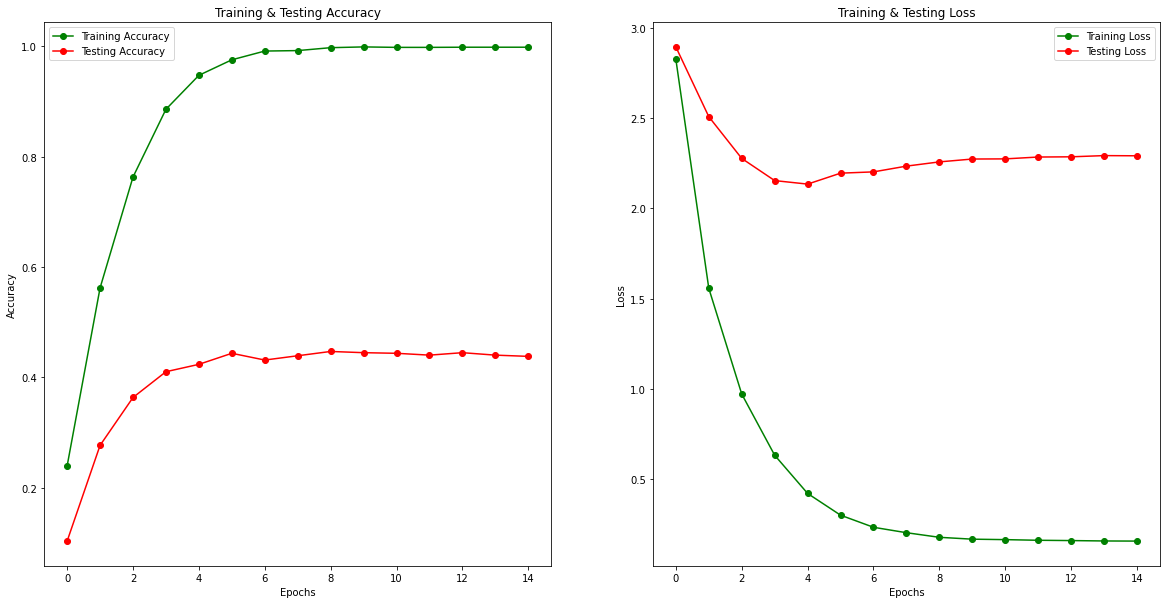

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [9]:
categories = ['Baby','Home Improvement','Pet Supplies','Kitchen & Dining',
              'Automotive','Computers','Cell Phones & Accessories',
              'Health & Personal Care','Beauty','Grocery & Gourmet Food',
              'Patio, Lawn & Garden','Arts, Crafts & Sewing',
              'Musical Instruments','Home &amp; Kitchen','Clothing',
              'Jewelry','Electronics','Camera & Photo','Watches','Shoes']

In [10]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = np.argmax(model.predict(test_images), axis=1)

print(classification_report(test_labels.astype(str), predictions.astype(str), target_names = categories))

                           precision    recall  f1-score   support

                     Baby       0.52      0.41      0.46        34
         Home Improvement       0.27      0.14      0.19        28
             Pet Supplies       0.38      0.46      0.42        24
         Kitchen & Dining       0.38      0.40      0.39        20
               Automotive       0.28      0.52      0.36        23
                Computers       0.25      0.25      0.25        16
Cell Phones & Accessories       0.57      0.57      0.57        21
   Health & Personal Care       0.79      0.81      0.80        32
                   Beauty       0.44      0.52      0.48        21
   Grocery & Gourmet Food       0.47      0.60      0.53        15
     Patio, Lawn & Garden       0.96      0.79      0.87        29
    Arts, Crafts & Sewing       0.64      0.90      0.75        20
      Musical Instruments       0.47      0.21      0.29        34
       Home &amp; Kitchen       0.40      0.20      0.27     

<AxesSubplot:>

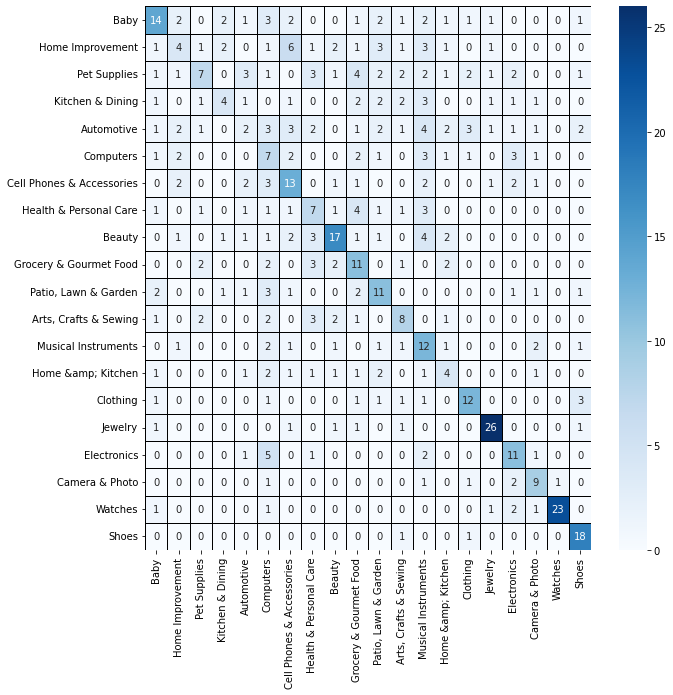

In [11]:
cm = confusion_matrix(test_labels,predictions)

cm = pd.DataFrame(cm , index = categories , columns = categories)
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', 
            xticklabels = categories , yticklabels =categories)